# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data represents 17 marketing campaigns conducted from May 2008 to November 2010, corresponding to a total of 79,354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [242]:
import pandas as pd
import numpy as np
import time
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.utils import resample


In [243]:
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep = ';')

In [244]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Alsoafter the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [246]:
# Summary of the DataFrame
print(df.info())

# Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values per feature:")
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [247]:
# For numerical features
print(df.describe())

               age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198    

In [248]:
# For categorical features
print(df.describe(include=['object']))

# Unique values in each categorical column
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']  # List of categorical columns
for col in categorical_columns:
    print(f"Unique values in {col}: {df[col].unique()}")

           job  marital          education default housing   loan   contact  \
count    41188    41188              41188   41188   41188  41188     41188   
unique      12        4                  8       3       3      3         2   
top     admin.  married  university.degree      no     yes     no  cellular   
freq     10422    24928              12168   32588   21576  33950     26144   

        month day_of_week     poutcome      y  
count   41188       41188        41188  41188  
unique     10           5            3      2  
top       may         thu  nonexistent     no  
freq    13769        8623        35563  36548  
Unique values in job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Unique values in marital: ['married' 'single' 'divorced' 'unknown']
Unique values in education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.deg

Missing months of jan and feb

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

The business objective is to use machine learning to predict the likelihood of a client subscribing to the term deposit, enabling the bank to optimize its marketing efforts and improve campaign efficiency.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [252]:
all_features = df.drop(columns=['y', 'duration'])

# Define ordinal features
ordinal_features = ['education', 'month', 'day_of_week']

# Specify the ordering for each ordinal column
education_order = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree', 'unknown']
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri']

# Define categorical feature for encoding
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

transformer = make_column_transformer((OrdinalEncoder(categories = [education_order]), ['education']), 
                                      (OrdinalEncoder(categories = [month_order]), ['month']), 
                                      (OrdinalEncoder(categories = [day_order]), ['day_of_week']),
                                      (OneHotEncoder(handle_unknown='ignore'), categorical_columns),
                                     remainder = StandardScaler())                                      


In [253]:
print(all_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [254]:
# Transform data and check 
transformed_data = transformer.fit_transform(all_features)

print(transformed_data[:5])

[[ 1.00000000e+00  4.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   1.53303429e+00 -5.65921974e-01  1.95413900e-01 -3.49494284e-01
   6.48092

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [256]:
X = all_features

y = df['y']

# Encode target variable as numeric
y = df['y'].map({'yes': 1, 'no': 0})

In [257]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [259]:
y_test.value_counts(normalize = True)

y
0    0.888026
1    0.111974
Name: proportion, dtype: float64

# If you were to always predict 0, your baseline accuracy would be 88.8%.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [262]:
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))

lgr_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])

# Fit the model and time it
lgr_start_time = time.time()
lgr_pipe.fit(X_train, y_train)
lgr_fit_time = time.time() - lgr_start_time 

lgr_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                              'high.school',
                                                                              'professional.course',
                                                                              'university.degree',
                                                                              'unknown']]),
                                                  ['education']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['jan',
                                                                              'feb',
                                                                              'mar',
                                                                              'apr',
                                                                              'may',
                                                                              'jun...
                                                                              'fri']]),
                                                  ['day_of_week']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('lgr', LogisticRegression(max_iter=1000, random_state=42))])

### Problem 9: Score the Model

What is the accuracy of your model?

In [264]:
lgr_acc_train = lgr_pipe.score(X_train, y_train)
lgr_acc_test = lgr_pipe.score(X_test, y_test)

print(lgr_acc_train)
print(lgr_acc_test)

0.9003269560713476
0.899970865300573


# The logistic regression model achieves 90.0% test accuracy, which is slightly better than the baseline of 88.8%.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [267]:
# KNN

# Create the KNN pipeline
knn_pipe = Pipeline([('transformer', transformer), ('knn', KNeighborsRegressor()])

# Fit the model and time it
knn_start_time = time.time()
knn_pipe.fit(X_train, y_train)
knn_fit_time = time.time() - knn_start_time 

# Score
knn_acc_train = knn_pipe.score(X_train, y_train)
knn_acc_test = knn_pipe.score(X_test, y_test)

# Check Results
print(f"Training R^2 Score: {knn_acc_train:.4f}")
print(f"Test R^2 Score: {knn_acc_test:.4f}")
print(f"Fit Time: {knn_fit_time:.4f} seconds")


Training R^2 Score: 0.2267
Test R^2 Score: 0.1985
Fit Time: 0.0978 seconds


In [268]:
# Decision Tree

# Create Pipe
dtree_pipe = Pipeline([('transformer', transformer), ('dtree', DecisionTreeClassifier(max_depth = 1))])

# Fit the model and time it
dtree_start_time = time.time()
dtree_pipe.fit(X_train, y_train)
dtree_fit_time = time.time() - dtree_start_time 

# Score
dtree_acc_train = dtree_pipe.score(X_train, y_train)
dtree_acc_test = dtree_pipe.score(X_test, y_test)

# Check Results
print(dtree_acc_train)
print(dtree_acc_test)
print(dtree_fit_time)

0.887119225664433
0.8880256385354958
0.14687108993530273


In [313]:
# Create the SVC pipeline
svc_start_time = time.time()
svc_pipe = Pipeline([
    ('transformer', transformer), 
    ('svc', SVC(kernel='linear', max_iter=30000, verbose=True))
])
svc_pipe.fit(X_train, y_train)

# Fit the model and time it
svc_fit_time = time.time() - svc_start_time 

# Score
svc_acc_train = svc_pipe.score(X_train, y_train)
svc_acc_test = svc_pipe.score(X_test, y_test)

# Check Results
print(f"Training Accuracy: {svc_acc_train:.4f}")
print(f"Test Accuracy: {svc_acc_test:.4f}")
print(f"Fit Time: {svc_fit_time:.4f} seconds")


[LibSVM]

C:\Users\carl1\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=30000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Accuracy: 0.8982
Test Accuracy: 0.8948
Fit Time: 21.3086 seconds


In [270]:
#Initialize df
model_comparison_df = pd.DataFrame(columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])

# Add Logistic Regression
model_comparison_df.loc[0] = ['Logistic Regression', lgr_fit_time, lgr_acc_train, lgr_acc_test] 

# Add knn
model_comparison_df.loc[1] = ['KNN', knn_fit_time, knn_acc_train, knn_acc_test]

# Add dtree
model_comparison_df.loc[2] = ['DTree', dtree_fit_time, dtree_acc_train, dtree_acc_test]

# Add svc
model_comparison_df.loc[3] = ['SVC', svc_fit_time, svc_acc_train, svc_acc_test]

# Print Table
print(model_comparison_df)


                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression    2.601748        0.900327       0.899971
1                  KNN    0.097783        0.226655       0.198523
2                DTree    0.146871        0.887119       0.888026
3                  SVC   24.898129        0.897834       0.896572


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [272]:
# Feature Importance - Logistic Regression
feature_names = lgr_pipe.named_steps['transformer'].get_feature_names_out() 
selected_features = feature_names[ [int(i[1:]) for i in lgr_pipe.named_steps['selector'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': lgr_pipe.named_steps['lgr'].coef_[0]})
coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)

# Check Results
coef_df.head(15)

,feature,coefs
46,emp.var.rate,2.220418
47,cons.price.idx,1.116142
31,month_jun,0.922519
33,month_may,0.895640
32,month_mar,0.841936
26,contact_telephone,0.757384
40,poutcome_failure,0.665951
34,month_nov,0.531747
27,month_apr,0.489434
37,day_of_week_mon,0.460814


In [417]:
from sklearn.decomposition import PCA

# Create the pipeline with PCA
lgr_pipe = Pipeline([
    ('transformer', transformer),                 
    ('pca', PCA(n_components=65)),                
    ('selector', SelectFromModel(LogisticRegression(
        penalty='l2', solver='lbfgs', random_state=42))),
    ('lgr', LogisticRegression(random_state=42, max_iter=10000))
])

# Fit the model and time it
lgr_start_time = time.time()
lgr_pipe.fit(X_train, y_train)
lgr_fit_time = time.time() - lgr_start_time 

# Evaluate the model
lgr_acc_train = lgr_pipe.score(X_train, y_train)
lgr_acc_test = lgr_pipe.score(X_test, y_test)

# Print Results
print(f"Training Accuracy: {lgr_acc_train:.4f}")
print(f"Test Accuracy: {lgr_acc_test:.4f}")
print(f"Fit Time: {lgr_fit_time:.4f} seconds")



Training Accuracy: 0.8982
Test Accuracy: 0.8946
Fit Time: 0.7541 seconds


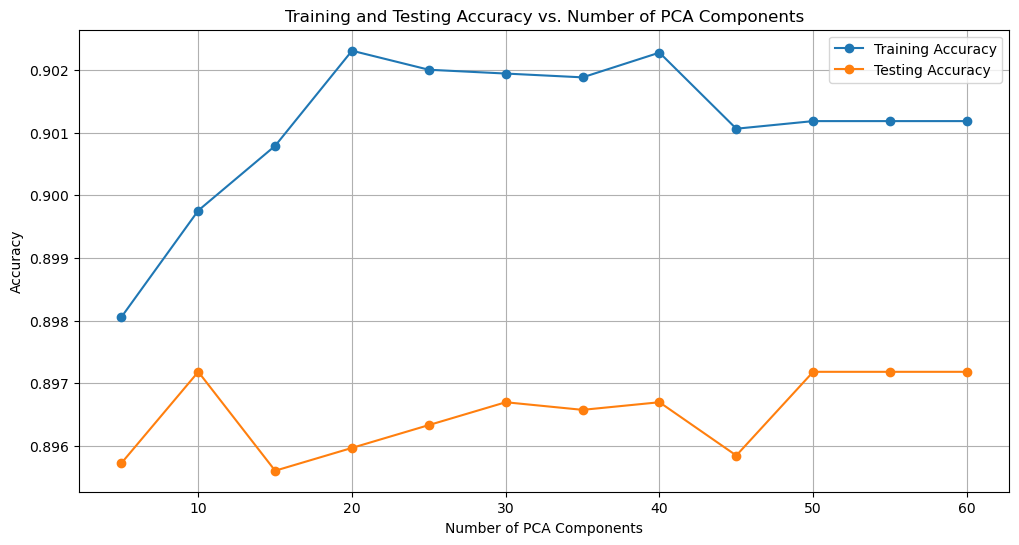

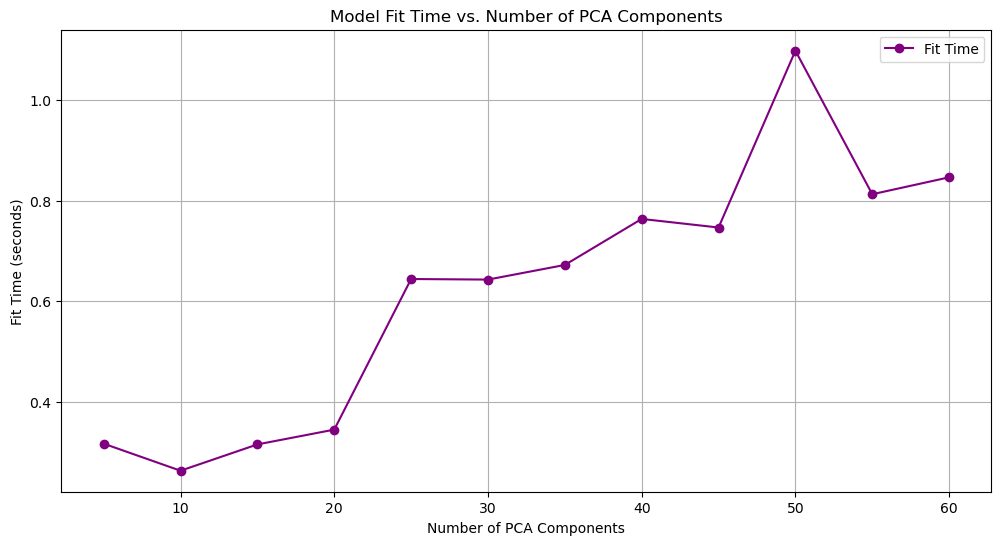

In [335]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import time

# Define PCA component increments
pca_components = range(5, 65, 5)  # Start from 10, increase in steps of 10

# Initialize lists to store results
train_accuracies = []
test_accuracies = []
fit_times = []

# Loop through different PCA component sizes
for n in pca_components:
    # Create the pipeline with PCA
    lgr_pipe = Pipeline([
        ('transformer', transformer),
        ('pca', PCA(n_components=n)),
        ('selector', SelectFromModel(LogisticRegression(
            penalty='l1', solver='liblinear', random_state=42))),
        ('lgr', LogisticRegression(random_state=42, max_iter=5000))
    ])
    
    # Fit the model and time it
    start_time = time.time()
    lgr_pipe.fit(X_train, y_train)
    fit_time = time.time() - start_time
    
    # Evaluate the model
    train_acc = lgr_pipe.score(X_train, y_train)
    test_acc = lgr_pipe.score(X_test, y_test)
    
    # Store results
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    fit_times.append(fit_time)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(pca_components, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(pca_components, test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs. Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Plot fit times
plt.figure(figsize=(12, 6))
plt.plot(pca_components, fit_times, label='Fit Time', marker='o', color='purple')
plt.xlabel('Number of PCA Components')
plt.ylabel('Fit Time (seconds)')
plt.title('Model Fit Time vs. Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()


In [273]:
# Feature Importance - DTree
p_0 = 0.888026
p_1 = 0.111974

# Entropy formula
all_entropy = -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))

# Answer check
print(all_entropy)


0.5058415755848766


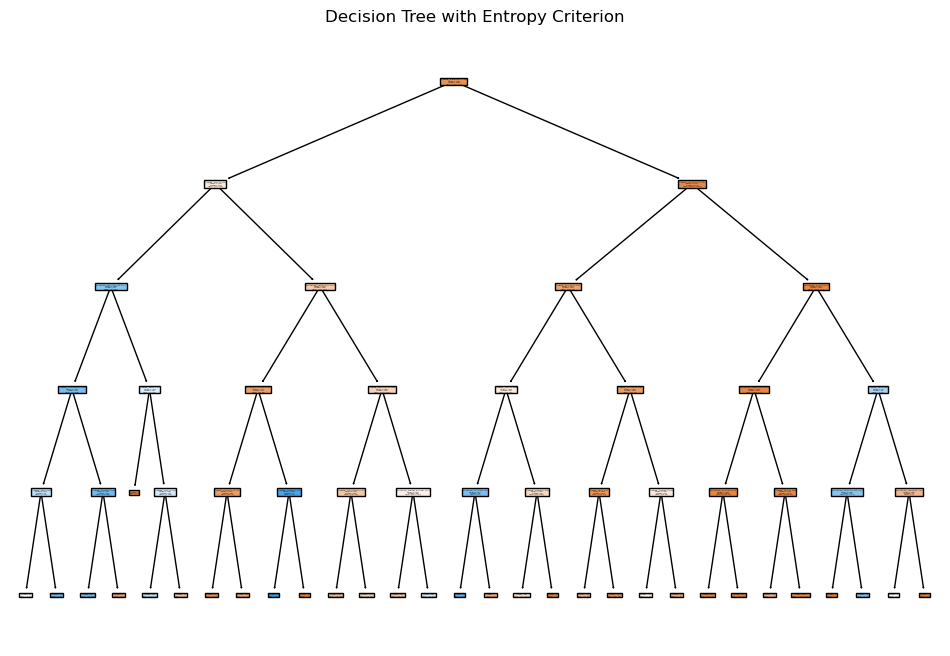

In [274]:

# Create the pipeline with the 'entropy' criterion
dtree_pipe_1 = Pipeline([
    ('transformer', transformer), 
    ('dtree', DecisionTreeClassifier(criterion='entropy', max_depth=5))
])

dtree_pipe_1.fit(X_train, y_train)

# Extract the decision tree model from the pipeline
dtree_model = dtree_pipe_1.named_steps['dtree']

# Get the transformed feature names
feature_names = dtree_pipe_1.named_steps['transformer'].get_feature_names_out()

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(
    dtree_model, 
    feature_names=feature_names,  # Use transformed feature names
    filled=True
)
plt.title('Decision Tree with Entropy Criterion')
plt.show()


In [275]:
# Extract feature importances
feature_importances = dtree_model.feature_importances_

# Pair with feature names
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importances_df)


                            Feature  Importance
64           remainder__nr.employed    0.657569
62         remainder__cons.conf.idx    0.105375
58                 remainder__pdays    0.085561
36  onehotencoder__contact_cellular    0.036974
63             remainder__euribor3m    0.032504
..                              ...         ...
34      onehotencoder__loan_unknown    0.000000
35          onehotencoder__loan_yes    0.000000
15  onehotencoder__marital_divorced    0.000000
14       onehotencoder__job_unknown    0.000000
0       ordinalencoder-1__education    0.000000

[65 rows x 2 columns]


In [276]:
# Sample a subset of the data
X_sample, y_sample = resample(X, y, n_samples=1000, random_state=42)

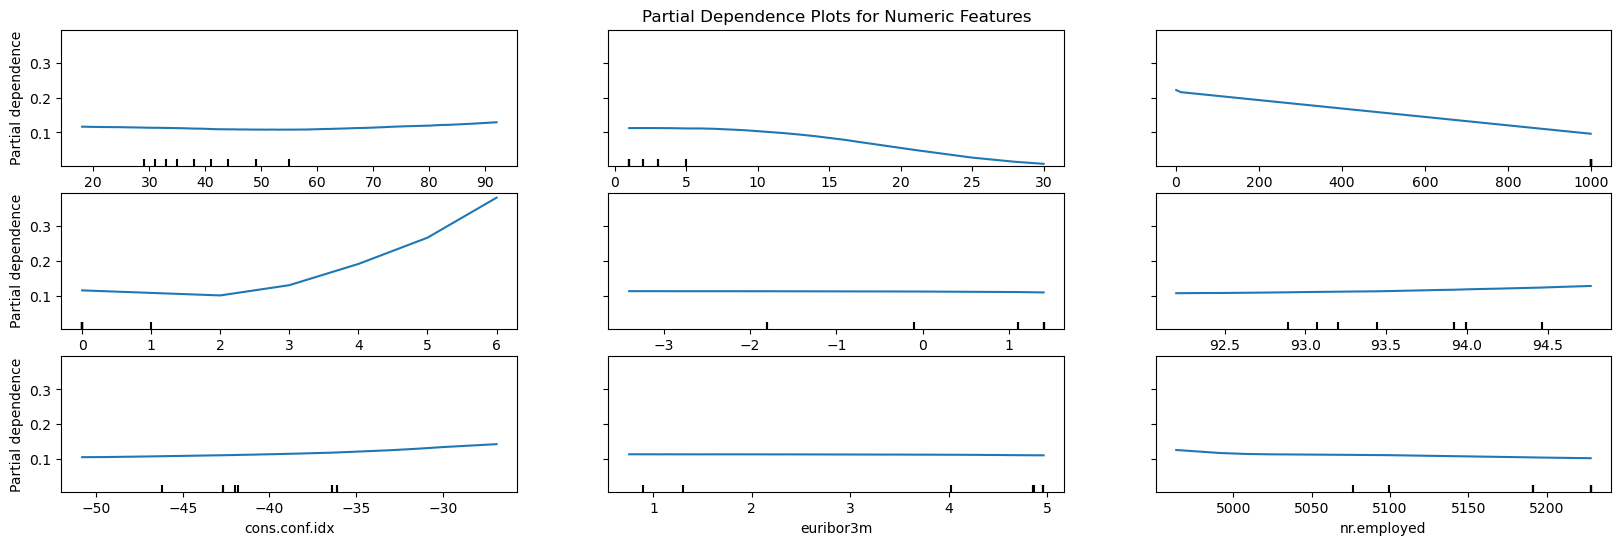

In [277]:
# Feature Importance - KNN

# Generate PDP with the smaller dataset
fig, ax = plt.subplots(figsize=(20, 6))
PartialDependenceDisplay.from_estimator(knn_pipe, X_sample, features=['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',  'euribor3m', 'nr.employed'], ax=ax)
ax.set_title('Partial Dependence Plots for Numeric Features')
plt.show()


In [357]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
import time

# Create the KNN pipeline with PCA
knn_pipe = Pipeline([
    ('transformer', transformer),  # Preprocessing step
    ('pca', PCA(n_components=65)),  # PCA with 10 components
    ('knn', KNeighborsRegressor(n_neighbors=100))  # KNN with 100 neighbors
])

# Fit the model and time it
knn_start_time = time.time()
knn_pipe.fit(X_train, y_train)
knn_fit_time = time.time() - knn_start_time 

# Score
knn_acc_train = knn_pipe.score(X_train, y_train)
knn_acc_test = knn_pipe.score(X_test, y_test)

# Check Results
print(f"Training R^2 Score: {knn_acc_train:.4f}")
print(f"Test R^2 Score: {knn_acc_test:.4f}")
print(f"Fit Time: {knn_fit_time:.4f} seconds")


Training R^2 Score: 0.2097
Test R^2 Score: 0.1883
Fit Time: 0.4059 seconds


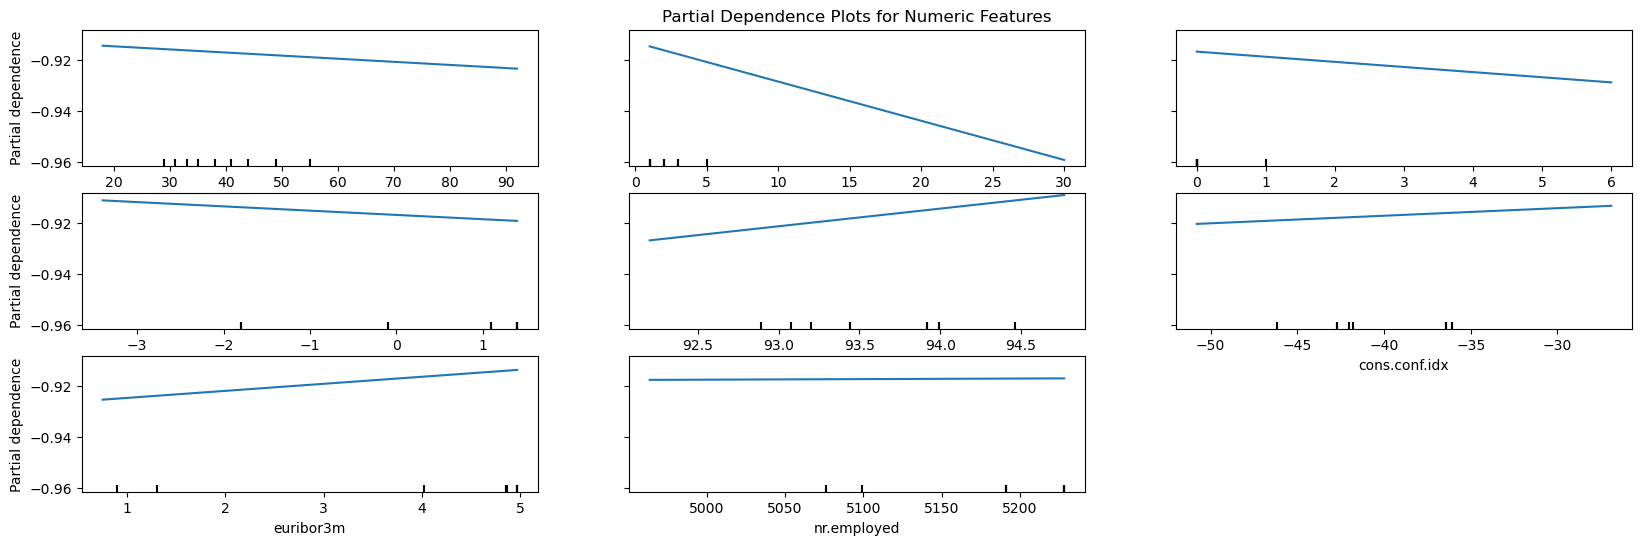

In [311]:
# Feature Importance - svc

# Generate PDP with the smaller dataset
fig, ax = plt.subplots(figsize=(20, 6))
PartialDependenceDisplay.from_estimator(svc_pipe, X_sample, features=['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',  'euribor3m', 'nr.employed'], ax=ax)
ax.set_title('Partial Dependence Plots for Numeric Features')
plt.show()
# 'pdays',
#features=['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',  'euribor3m', 'nr.employed'], ax=ax)


In [423]:
# Create the SVC pipeline with PCA
svc_start_time = time.time()
svc_pipe = Pipeline([
    ('transformer', transformer),  
    ('pca', PCA(n_components=20)),  
    ('svc', SVC(kernel='rbf', gamma=0.1, max_iter=30000, verbose=True)) 
])

# Fit the model and time it
svc_pipe.fit(X_train, y_train)
svc_fit_time = time.time() - svc_start_time 

# Score
svc_acc_train = svc_pipe.score(X_train, y_train)
svc_acc_test = svc_pipe.score(X_test, y_test)

# Check Results
print(f"Training Accuracy: {svc_acc_train:.4f}")
print(f"Test Accuracy: {svc_acc_test:.4f}")
print(f"Fit Time: {svc_fit_time:.4f} seconds")


[LibSVM]

C:\Users\carl1\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=30000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Accuracy: 0.9116
Test Accuracy: 0.8974
Fit Time: 29.6109 seconds


Best Parameters: {'dtree__max_depth': 5, 'dtree__min_samples_leaf': 3, 'dtree__min_samples_split': 2}
Best Cross-Validation Accuracy: 0.9012
Test Set Accuracy: 0.8967


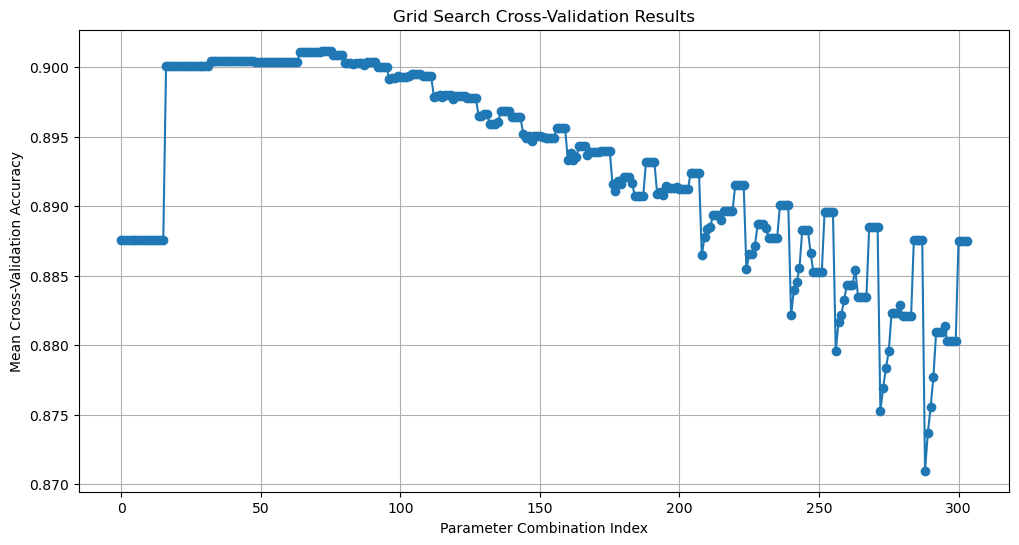

In [429]:
# Create the pipeline
dtree_pipe = Pipeline([
    ('transformer', transformer),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

# Define the hyperparameter grid
param_grid = {
    'dtree__max_depth': range(1, 10),
    'dtree__min_samples_split': [2, 3, 4, 5],
    'dtree__min_samples_leaf': [1, 2, 3, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(
    dtree_pipe,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    n_jobs=-1
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)

# Print Results
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
mean_test_scores = grid_search.cv_results_['mean_test_score']
param_combinations = len(mean_test_scores)
plt.plot(range(param_combinations), mean_test_scores, marker='o')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Grid Search Cross-Validation Results')
plt.grid(True)
plt.show()




# Create Pipe

# Create the pipeline
svc_pipe = Pipeline([('transformer', transformer), ('svc', SVC(max_iter=3000, verbose=True))])

# Define the parameter grid 
params = {
    'svc__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
    'svc__gamma': [0.1, 0.2, 0.3, 0.4],
}

# Perform Grid Search with the pipeline
grid = GridSearchCV(svc_pipe, param_grid=params, cv=5)
svc_start_time = time.time()
grid.fit(X_train, y_train)
svc_fit_time = time.time() - svc_start_time

# Evaluate on the test set
grid_score = grid.score(X_test, y_test)

# Print the best parameters and test score
print("Best Parameters:", grid.best_params_)
print("Test Set Accuracy:", grid_score)
print(f"SVC Fit Time: {svc_fit_time:.4f} seconds")



In [ ]:
# KNN Hyperparameter Tuning

# Create the KNN pipeline
knn_pipe = Pipeline([
    ('transformer', transformer),
    ('knn', KNeighborsRegressor())
])

# Define the hyperparameter grid
params = {'knn__n_neighbors': range(1, 100, 2)}

# Perform Grid Search
knn_grid = GridSearchCV(knn_pipe, param_grid=params, cv=5)
knn_grid.fit(X, y)  

# Get the best number of neighbors
best_k = knn_grid.best_params_['knn__n_neighbors']

# Answer check
print(f"Best k: {best_k}")


In [435]:

# KNN
knn_pipe = Pipeline([
    ('transformer', transformer),
    ('knn', KNeighborsRegressor(n_neighbors=99))
])

# Fit the model and time it
knn_start_time = time.time()
knn_pipe.fit(X_train, y_train)
knn_fit_time_opt = time.time() - knn_start_time 

# Score
knn_acc_train_opt = knn_pipe.score(X_train, y_train)
knn_acc_test_opt = knn_pipe.score(X_test, y_test)

# Check Results
print(f"KNN Training R^2 Score: {knn_acc_train_opt:.4f}")
print(f"KNN Test R^2 Score: {knn_acc_test_opt:.4f}")
print(f"KNN Fit Time: {knn_fit_time_opt:.4f} seconds")

# Create dtree with optimized parameters
dtree_pipe = Pipeline([
    ('transformer', transformer),
    ('dtree', DecisionTreeClassifier(
        max_depth=5,  # Optimized max_depth
        min_samples_leaf=3,  # Optimized min_samples_leaf
        min_samples_split=2,  # Optimized min_samples_split
        random_state=42  # Ensures reproducibility
    ))
])

# Fit the model and time it
dtree_start_time = time.time()
dtree_pipe.fit(X_train, y_train)
dtree_fit_time_opt = time.time() - dtree_start_time 

# Score
dtree_acc_train_opt = dtree_pipe.score(X_train, y_train)
dtree_acc_test_opt = dtree_pipe.score(X_test, y_test)

# Check Results
print(f"Dtree Training Accuracy: {dtree_acc_train_opt:.4f}")
print(f"Dtree Test Accuracy: {dtree_acc_test_opt:.4f}")
print(f"DtreeFit Time: {dtree_fit_time_opt:.4f} seconds")

# SVC with Best Parameters
svc_pipe = Pipeline([
    ('transformer', transformer),
    ('svc', SVC(kernel='rbf', max_iter=30000, gamma=0.1, random_state=42))
])


# Fit the model and time it
svc_start_time = time.time()
svc_pipe.fit(X_train, y_train)
svc_fit_time_opt = time.time() - svc_start_time 

# Score
svc_acc_train_opt = svc_pipe.score(X_train, y_train)
svc_acc_test_opt = svc_pipe.score(X_test, y_test)

# Check Results
print(f"SVC Training Accuracy: {svc_acc_train_opt:.4f}")
print(f"SVC Test Accuracy: {svc_acc_test_opt:.4f}")
print(f"SVC Fit Time: {svc_fit_time_opt:.4f} seconds")

KNN Training R^2 Score: 0.2274
KNN Test R^2 Score: 0.1941
KNN Fit Time: 0.1953 seconds
Dtree Training Accuracy: 0.9045
Dtree Test Accuracy: 0.8967
DtreeFit Time: 0.2678 seconds


C:\Users\carl1\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=30000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC Training Accuracy: 0.9173
SVC Test Accuracy: 0.8965
SVC Fit Time: 68.3944 seconds


In [437]:
# Compare performance of optimized models with default models
#Initialize df
model_comparison_df = pd.DataFrame(columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])

# Add Logistic Regression
model_comparison_df.loc[0] = ['Logistic Regression', lgr_fit_time, lgr_acc_train, lgr_acc_test] 

# Add knn
model_comparison_df.loc[1] = ['KNN', knn_fit_time, knn_acc_train, knn_acc_test]

# Add dtree
model_comparison_df.loc[2] = ['DTree', dtree_fit_time, dtree_acc_train, dtree_acc_test]

# Add svc
model_comparison_df.loc[3] = ['SVC', svc_fit_time, svc_acc_train, svc_acc_test]

# Add knn
model_comparison_df.loc[4] = ['KNN Optimized', knn_fit_time_opt, knn_acc_train_opt, knn_acc_test_opt]

# Add dtree
model_comparison_df.loc[5] = ['DTree Optimized', dtree_fit_time_opt, dtree_acc_train_opt, dtree_acc_test_opt]

# Add svc
model_comparison_df.loc[6] = ['SVC Optimized', svc_fit_time_opt, svc_acc_train_opt, svc_acc_test_opt]

# Print Table
print(model_comparison_df)

                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression    0.754133        0.898179       0.894635
1                  KNN    0.405867        0.209717       0.188285
2                DTree    0.146871        0.887119       0.888026
3                  SVC   29.610942        0.911563       0.897427
4        KNN Optimized    0.195322        0.227398       0.194096
5      DTree Optimized    0.267781        0.904522       0.896698
6        SVC Optimized   68.394374        0.917269       0.896455


##### Questions